# 🔍 Predicting Item Prices from Descriptions (Part 7)
---
- Data Curation & Preprocessing
- Model Benchmarking – Traditional ML vs LLMs
- E5 Embeddings & RAG
- Fine-Tuning GPT-4o Mini
- Evaluating LLaMA 3.1 8B Quantized
- Fine-Tuning LLaMA 3.1 with QLoRA
- ➡️ Evaluating Fine-Tuned LLaMA
- Summary & Leaderboard

---

# 🧪 Part 7: Evaluating the Fine-Tuned LLaMA 3.1 8B (Quantized)

- ⚙️ Hardware: ⚠️ GPU required - use Google Colab
- 🛠️ Requirements: 🔑 HF Token
- Tasks:
    - Load the tokenizer and fine-tuned base model
    - Load the PEFT adapter for the fine-tuned weights
    - Run evaluation — the moment of truth!

🔔 **Reminder:**  
As mentioned in Part 6, I fine-tuned the model on only 20K samples.  
In this notebook, we’ll evaluate both this model and the full 400K-sample version fine-tuned by our instructor.

In [ ]:
# pip installs

!pip install -q datasets peft torch bitsandbytes transformers matplotlib

In [ ]:
# imports

import math, torch
from huggingface_hub import login
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from datasets import load_dataset
from peft import PeftModel
import matplotlib.pyplot as plt
from google.colab import userdata

In [ ]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [ ]:
# Helper class for evaluating model predictions

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        # print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)

        # Add color legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Accurate (green)', markerfacecolor='green', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Medium error (orange)', markerfacecolor='orange', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='High error (red)', markerfacecolor='red', markersize=8)
        ]
        plt.legend(handles=legend_elements, loc='upper right')

        plt.show()


    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

# 📥 Load Dataset

In [ ]:
DATASET_NAME = "Lizk75/pricer-data"
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

README.md:   0%|          | 0.00/416 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/183M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/905k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
test[0]

{'text': 'How much does this cost to the nearest dollar?\n\nSolera Slide Topper Slide-Out Protection for RVs, Travel Trailers, 5th Wheels, and Motorhomes\nTired of dirt, leaves and bird droppings piling up on your slide-out? Solera® Slide Toppers are an economical, attractive way for you to help protect your RV’s slide-out from debris and water infiltration. Compatible with leading slide-out brands on the market today, our Slide Topper awnings automatically extend and retract, right along with your slide-out — giving you automatic protection, every time.Our heavy-duty, 13.5 oz. Slide Topper vinyl is constructed with heat-welded, leak-resistant seams to prevent water infiltrations and seam damage — plus, it’s designed to withstand -25 degrees Fahrenheit, so it won’t crack in\n\nPrice is $',
 'price': 368.43}

# 📥 Load Tokenizer and Model
The fine-tuned model (PeftModel) only holds the LoRA adapters, so it requires the base model to apply them correctly.

In [ ]:
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Reduce the precision to 4 bits
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

# 🧪 Load and Evaluate the Fine-Tuned Model with PEFT Adapters

## 20K Sample Fine-Tuned Model

In [ ]:
# Load LizK model (trained on 20K datapoints)

FINETUNED_MODEL = "Lizk75/llama3-pricer-2025-04-08_18.44.04-size20000"
fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)
print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")
fine_tuned_model

adapter_config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

Memory footprint: 5700.6 MB


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

In [ ]:
# Gets top 3 predicted tokens from the model
# Filters valid numeric outputs (prices)
# Returns a weighted average based on token probabilities

# This code would be more complex if we couldn't take advantage of the fact
# That Llama generates 1 token for any 3 digit number

top_K = 3

def improved_model_predict(prompt, device="cuda"):
    set_seed(42) # Reproducibility : same prompt = same o/p every time
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad(): # Do not track gradients during inference
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)

    prices, weights = [], [] # weights = corresponding probabilities

    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]

      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0

      if result > 0:
        prices.append(result)
        weights.append(probability)

    if not prices:
      return 0.0, 0.0

    total = sum(weights)

    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]

    return sum(weighted_prices).item()

In [ ]:
improved_model_predict(test[0]["text"], device="cuda")

264.75

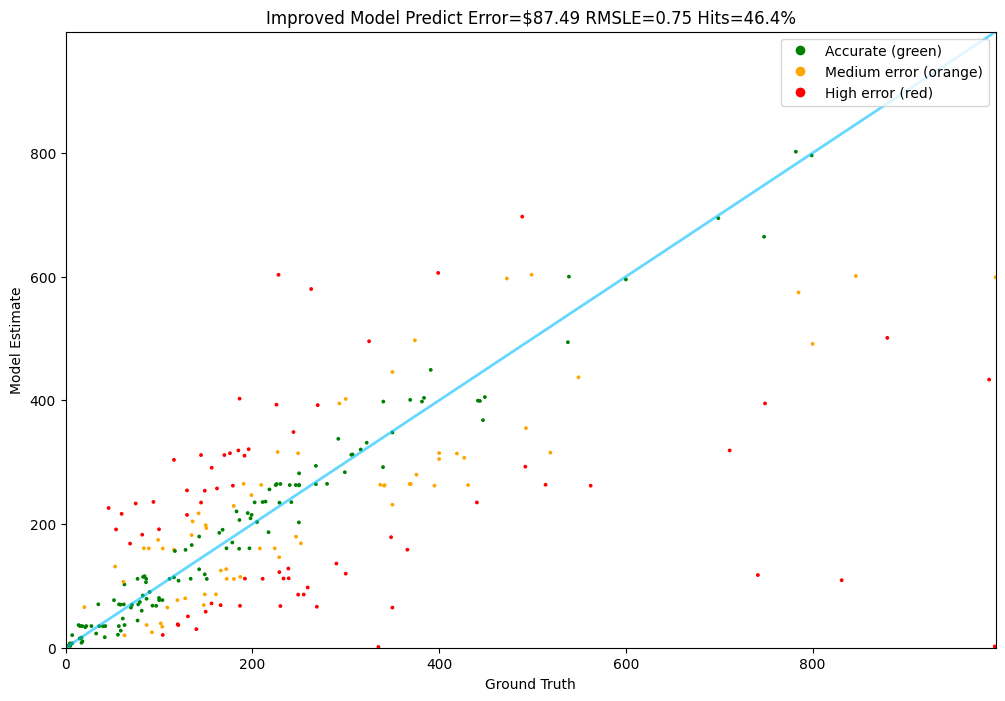

In [ ]:
Tester.test(improved_model_predict, test)

## 400K Sample Fine-Tuned Model

In [ ]:
FINETUNED_MODEL = "ed-donner/pricer-2024-09-13_13.04.39"
REVISION = "e8d637df551603dc86cd7a1598a8f44af4d7ae36"
fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")
fine_tuned_model

adapter_config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

Memory footprint: 5700.6 MB


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

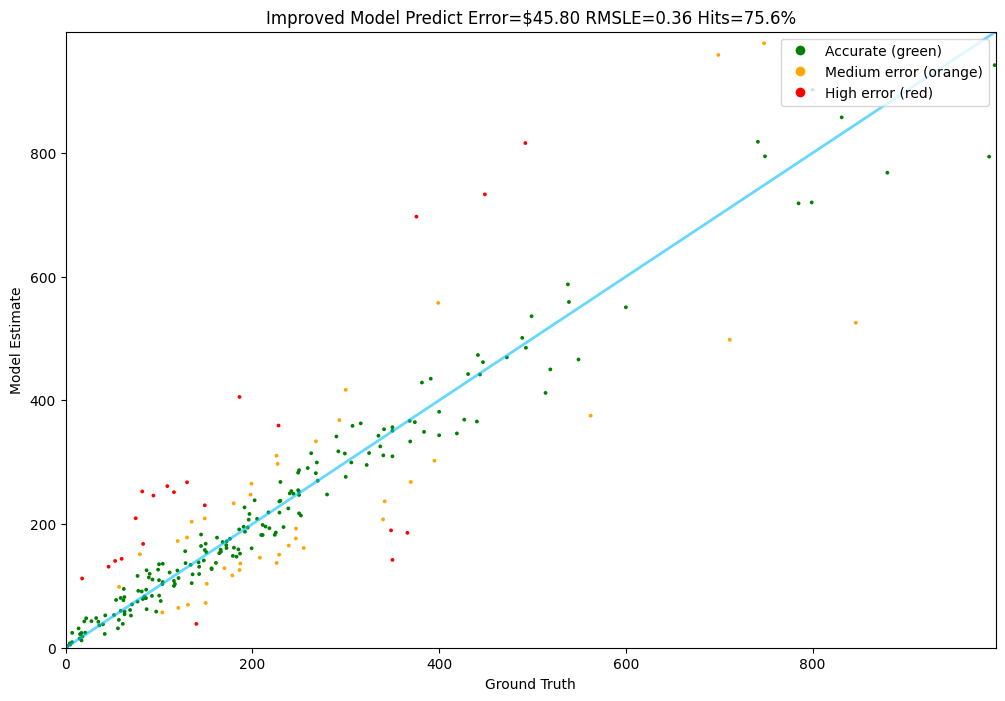

In [ ]:
Tester.test(improved_model_predict, test)

🎉  And there it is — the open-source, quantized, and fine-tuned model outperforms the rest. 🙌 

📘 We'll continue in the next notebook with a final wrap-up and summary of key insights.